In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


## EDA

In [4]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

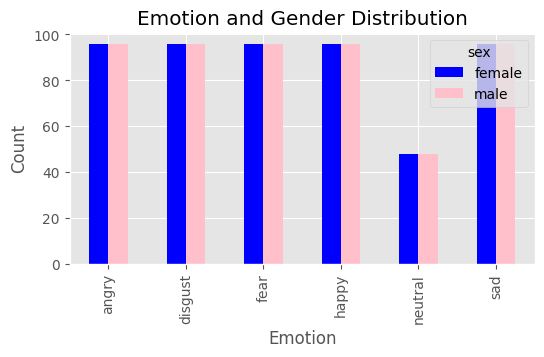

In [5]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['blue', 'pink'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(ravdess_df)

In [6]:
## Taking Just one gender, 
##ravdess_df = ravdess_df[ravdess_df['sex'] == 'male']

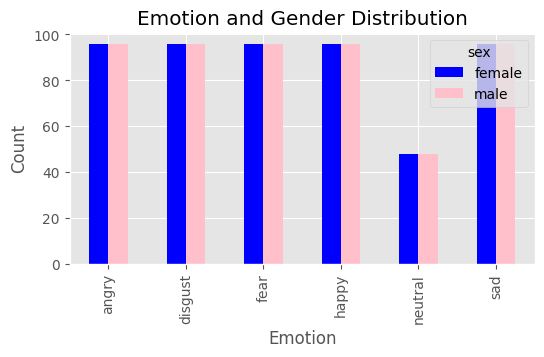

In [7]:
plot_distribution(ravdess_df)

In [8]:
ravdess_df.drop('sex', axis=1, inplace=True)
ravdess_df.head()

,path,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,fear


In [9]:
ravdess_df.shape

(1056, 2)

## Plotting waveforms

In [10]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

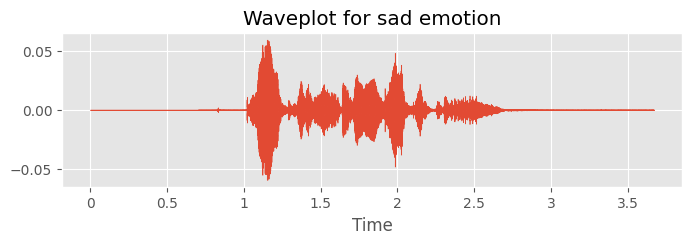

In [11]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(ravdess_df.path[ravdess_df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

In [12]:
emotion_dict = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def label_naming(label):
    return emotion_dict.get(label)

### The audio is in wav format, now to feed to to a neural network it has to be converted to arrays, also the it should be made to equal length, either by padding the sequences or by deleting some portion from it

In [13]:
from pydub import AudioSegment, effects
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    if len(trimmed) > 180000:
        trimmed = trimmed[:180000] 
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

## Feature Extraction

### Various Techniques such as MFCC, RMSE, Zero crossing rate, are done and are concatenated to create a unique feature vector

In [14]:
rmse_list = []
mfccs_list = []
emotion_list = []
zcr_list = []
FRAME_LENGTH = 2048
HOP_LENGTH = 1048

## Frame length is actually the window size, where each window produces mfcc, zcr features for the window,
## Hop-length is the overlapping size among the window, here frameLength is 2048 and hop is 1048, so
## 50% overlapping.

for row in ravdess_df.itertuples(index=False):
    
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        
        ## MFCC's along with their delta's
        
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        delta_mfccs = librosa.feature.delta(mfccs)
        double_delta_mfccs = librosa.feature.delta(delta_mfccs)
        final_mfccs = np.concatenate((mfccs, delta_mfccs, double_delta_mfccs), axis=0)

        zcr_list.append(zcr)
        rmse_list.append(rms)
        mfccs_list.append(final_mfccs)

        emotion_list.append(label_naming(row.emotion))

## Concatenation to create a unique vector

In [15]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rmse_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

## All the preprocess done and data is ready to be feeded to the model

### Since it's Time Series data, we are using LSTM Architecture

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks

2024-03-25 20:25:58.121096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 20:25:58.121190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 20:25:58.252798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.4, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [18]:
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(X.shape[1:3])))
model.add(layers.Dropout(0.2))  
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dropout(0.2))  
model.add(layers.Dense(6, activation='softmax'))

print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 172, 128)       │        54,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 172, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,862 (601.02 KB)

 Trainable params: 153,862 (601.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
call_rop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])

In [21]:
history = model.fit(X_train, y_train_class, epochs=200, batch_size=32, validation_data=(X_val, y_val_class))

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - categorical_accuracy: 0.2592 - loss: 1.7053 - val_categorical_accuracy: 0.3858 - val_loss: 1.5114
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.3297 - loss: 1.5340 - val_categorical_accuracy: 0.4488 - val_loss: 1.4959
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.3732 - loss: 1.4792 - val_categorical_accuracy: 0.4488 - val_loss: 1.4110
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.4212 - loss: 1.3923 - val_categorical_accuracy: 0.4252 - val_loss: 1.3693
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.4669 - loss: 1.3290 - val_categorical_accuracy: 0.5118 - val_loss: 1.2877
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.4301 - loss: 1.3444 - val_categorical_accuracy: 0.4646 - val_loss: 1.3861
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.4587 - los

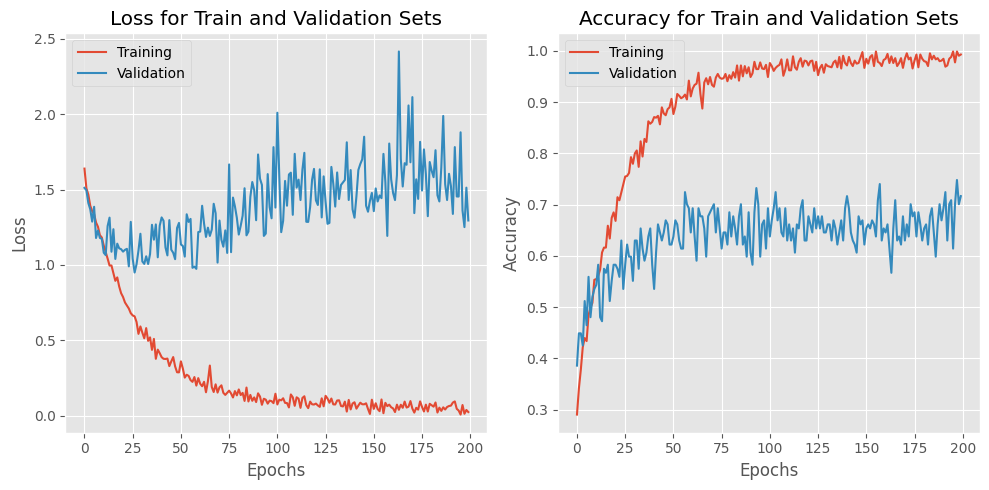

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(history.history['categorical_accuracy'])
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

## Confusion Matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


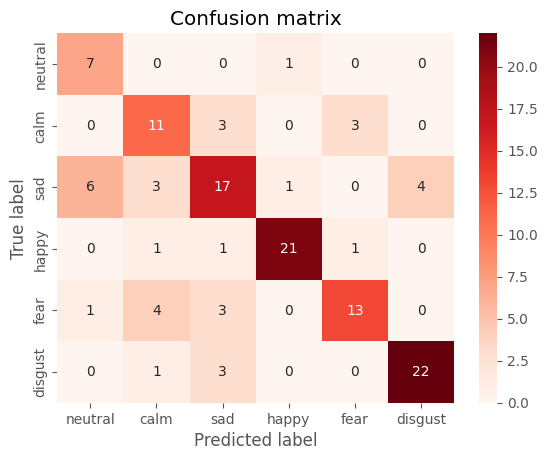

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()